# Text to Image with Generative AI

---

In this notebook, the Amazon SageMaker Python SDK is used for text-to-image tasks, generating realistic images from any text input through state-of-the-art, pre-trained Stable Diffusion models.

---

1. [Set up](#1.-Set-up)
2. [Select a model](#2.-Select-a-model)
3. [Retrieve JumpStart artifacts and deploy an endpoint](#3.-Retrieve-JumpStart-artifacts-and-deploy-an-endpoint)
4. [Query the endpoint and parse the response](#4.-Query-the-endpoint-and-parse-the-response)
5. [Advanced features](#5.-Advanced-features)
6. [Clean up the endpoint](#6.-Clean-up-the-endpoint)

Note: This notebook was tested on an ml.m5.xlarge instance in Amazon SageMaker Studio with a Python 3 (Data Science) kernel and in an Amazon SageMaker Notebook instance with a conda_python3 kernel.

### 1. Set up

#### Permissions and environment variables

---
To host on Amazon SageMaker, we must first set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. 

---

In [2]:
#Install matplotlib library
!pip install matplotlib

# Import python libraries
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name

# Get the correct Amazon S3 bucket name.
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')

s3 = boto3.resource('s3')

# Get the name of the S3 bucket with the prefix, lab-code.
for bucket in s3.buckets.all():
    if bucket.name.startswith('lab-code'):
        mybucket = bucket.name
        print(mybucket)
sess = sagemaker.Session(default_bucket = mybucket)


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
lab-code-849d8840
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### 2. Select a model

***
A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).
***

In [3]:
model_id, model_version = "model-txt2img-stabilityai-stable-diffusion-v2", "1.*"

### 3. Retrieve artifacts and deploy an endpoint

***

Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. We start by retrieving `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance, [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html), and deploy it. This might take a few minutes.

***

In [4]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"text-to-image-{model_id}")

# Use ml.g5.24xlarge instance type if it is available in your Region. 
# The ml.g5.24xlarge instance type has 24 GB GPU compared to 16 GB in ml.p3.2xlarge, and it supports the generation of larger and better quality images.
inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference Docker container URI. This is the base HuggingFace container image for the previous default model.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
    sagemaker_session=sess,
)

# Retrieve the inference script URI. This includes all dependencies and scripts for model loading, inference handling, and so on.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model URI. This includes the pre-trained model and parameters.
model_uri = model_uris.retrieve(
                    model_id=model_id, 
                    model_version=model_version, 
                    model_scope="inference",
                    sagemaker_session=sess,
)

# Increase the maximum response size from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE":'20000000',
}

# Create the SageMaker model instance.
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env = env,
    sagemaker_session=sess,
)

# Deploy the model. To run inference through the Sagemaker API, we need to pass the Predictor class when we deploy the model through the Model class.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
)

Using model 'model-txt2img-stabilityai-stable-diffusion-v2' with wildcard version identifier '1.*'. You can pin to version '1.2.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.
Using model 'model-txt2img-stabilityai-stable-diffusion-v2' with wildcard version identifier '1.*'. You can pin to version '1.2.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.
Using model 'model-txt2img-stabilityai-stable-diffusion-v2' with wildcard version identifier '1.*'. You can pin to version '1.2.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


-----------!

### 4. Query the endpoint and parse the response

---
Input to the endpoint is any string of text dumped in JSON and encoded in `utf-8` format. Output of the endpoint is a `json` with generated text.

---

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt."""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

---
Next, we put in some example input text. You can put in any text, and the model predicts the image corresponding to that text.

---

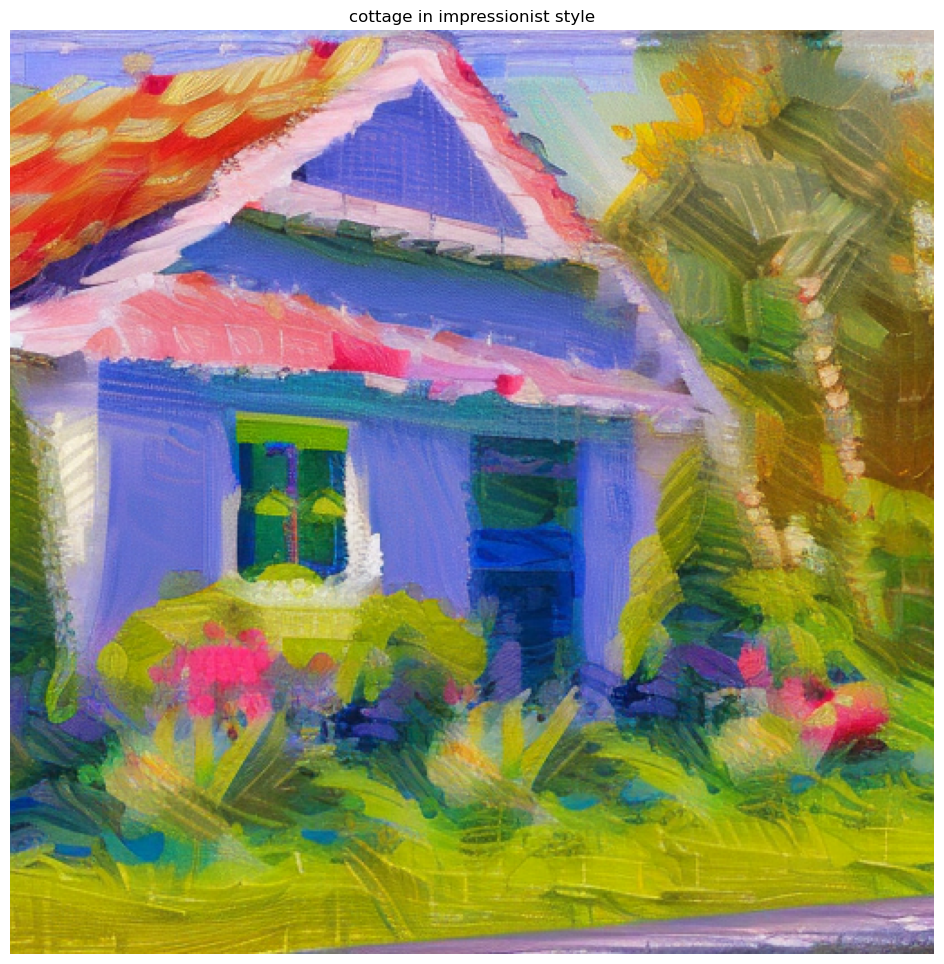

In [6]:
text = "cottage in impressionist style"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

### 5. Advanced features

***
This model also supports many advanced parameters while performing inference. The parameters include:

* **prompt**: The guide for image generation. It must be specified, and it can be a string or a list of strings.
* **width**: The width of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **height**: The height of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **num_inference_steps**: The number of denoising steps during image generation. More steps lead to a higher quality image. If specified, it must a positive integer.
* **guidance_scale**: A higher guidance scale results in an image closely related to the prompt, at the expense of image quality. If specified, it must be a float. (guidance_scale<=1 is ignored)
* **negative_prompt**: Guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings, then negative_prompt must also be a list of strings. 
* **num_images_per_prompt**: The number of images returned per prompt. If specified, it must be a positive integer. 
* **seed**: Fix the randomized state for reproducibility. If specified, it must be an integer.
***

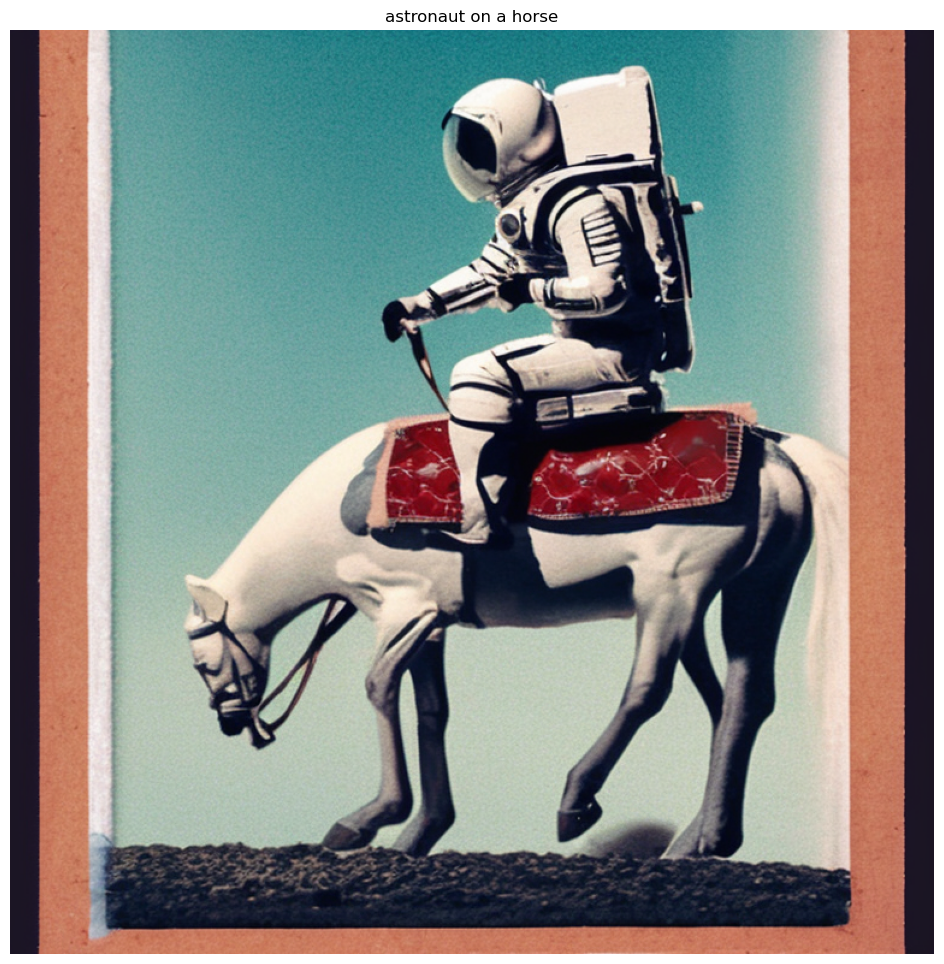

In [7]:
import json

# Stable Diffusion 2.0 was trained on images with the dimension, 768x768, and it achieves the best performance when the generated image size is 768x768. If you used the instance type, ml.g5.16xlarge, for deployment, you can replace a width and height larger than 768.
payload = {
    "prompt": "astronaut on a horse",
    "width": 768,
    "height": 768,
    "num_images_per_prompt": 1,
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
}


def query_endpoint_with_json_payload(model_predictor, payload):
    """Query the model predictor with json payload."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": "application/json",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response_multiple_images(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


query_response = query_endpoint_with_json_payload(model_predictor, payload)
generated_images, prompt = parse_response_multiple_images(query_response)

for img in generated_images:
    display_img_and_prompt(img, prompt)

### 6. Clean up the endpoint

In [8]:
# Delete the SageMaker endpoint.
# model_predictor.delete_model()
# model_predictor.delete_endpoint()